# Plotting DISCOVR EPIC Level-2 ozone product parameters

## Summary

This code graphs 4 different parameters from the DSCOVR EPIC Level 2 Total Ozone, Version 3 product
(Ozone, Reflectivity, Radiative Cloud Fraction, Cloud Pressure).

## Reference

Code Reference: [https://hdfeos.org/zoo/LaRC/DSCOVR_EPIC_L2_TO3_03_20210301005516_03.h5.py](https://hdfeos.org/zoo/LaRC/DSCOVR_EPIC_L2_TO3_03_20210301005516_03.h5.py)

For more information on this data product please vist:
[https://avdc.gsfc.nasa.gov/pub/DSCOVR/EPIC_Pulications/EPICTO3UserGuide_final.pdf](https://avdc.gsfc.nasa.gov/pub/DSCOVR/EPIC_Pulications/EPICTO3UserGuide_final.pdf)

## Prerequisites

A free(!) account at https://www.earthdata.nasa.gov/ is needed to login and download the appropriate files.

This notebook was written using Python 3.8.10, and requires these libraries:

- [cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/)
- [h5py](https://docs.h5py.org/en/stable/index.html)
- [matplotlib](http://matplotlib.org/)
- [numpy](https://numpy.org/)

### Notebook Author / Affiliation
Cheyenne Land / Atmospheric Science Data Center

## 1. Setup

In [1]:
import cartopy.crs as ccrs
import earthaccess
import h5py
import matplotlib.pyplot as plt
import numpy as np
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

## 2. Search for data using earthaccess

We use `earthaccess` to streamline the login to NASA Earthdata. 

<details open>
  <summary><i>Additional resources about earthaccess</i></summary>

- [*earthaccess* documentation](https://earthaccess.readthedocs.io/en/latest/)
- [Earthdata Cloud Cookbook](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/tutorials/earthaccess-demo.html)
</details>

In [2]:
earthaccess.login()

In [3]:
short_name = "DSCOVR_EPIC_L2_TO3"
version = "03"

results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    temporal=("2025-02-01T00:00:00", "2025-02-01T04:59:59"),
)
print(f"{len(results)} file(s) found.")

3 file(s) found.


In [4]:
print(results)

[Collection: {'ShortName': 'DSCOVR_EPIC_L2_TO3', 'Version': '03'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 61.662150027, 'Longitude': 180}, {'Latitude': 60.881559768, 'Longitude': 170.550246061}, {'Latitude': 59.446416148, 'Longitude': 161.575307495}, {'Latitude': 57.385378569, 'Longitude': 153.243755735}, {'Latitude': 56.122062602, 'Longitude': 149.324365749}, {'Latitude': 54.706096953, 'Longitude': 145.575778651}, {'Latitude': 53.148679682, 'Longitude': 142.018043035}, {'Latitude': 51.433576429, 'Longitude': 138.607151533}, {'Latitude': 49.558332996, 'Longitude': 135.337891006}, {'Latitude': 47.513590642, 'Longitude': 132.194088825}, {'Latitude': 45.295254258, 'Longitude': 129.169700771}, {'Latitude': 42.898989395, 'Longitude': 126.257268024}, {'Latitude': 40.30613302, 'Longitude': 123.43351568}, {'Latitude': 37.503747539, 'Longitude': 120.685219083}, {'Latitude': 30.389841383, 'Longitude': 116.161716326}, {'Latit

## 3. Download data

In [5]:
downloaded_files = earthaccess.download(results, local_path=".")
downloaded_files

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

['DSCOVR_EPIC_L2_TO3_03_20250201004554_03.h5',
 'DSCOVR_EPIC_L2_TO3_03_20250201023356_03.h5',
 'DSCOVR_EPIC_L2_TO3_03_20250201042158_03.h5']

## 4. Open the files

In [6]:
arrays = {
    "ozone": [],
    "reflectivity": [],
    "rcf": [],
    "cp": [],
    "lon": [],
    "lat": [],
    "lon_m": [],
    "lat_m": [],
}

for file in downloaded_files:
    with h5py.File(file, mode="r") as f:
        ozone = f["/Ozone"][:].astype(np.float64)
        reflectivity = f["/Reflectivity"][:].astype(np.float64)
        RCF = f["/RadiativeCloudFraction"][:].astype(np.float64)
        CP = f["/CloudPressure"][:].astype(np.float64)
        lon = f["/Longitude"][:]
        lat = f["/Latitude"][:]

        # Set fill value for each variable
        FillValue = -999.0

        ozone[ozone == FillValue] = np.nan
        arrays["ozone"].append(np.ma.masked_where(np.isnan(ozone), ozone))

        reflectivity[reflectivity == FillValue] = np.nan
        arrays["reflectivity"].append(np.ma.masked_where(np.isnan(reflectivity), reflectivity))

        RCF[RCF == FillValue] = np.nan
        arrays["rcf"].append(np.ma.masked_where(np.isnan(RCF), RCF))

        CP[CP == FillValue] = np.nan
        arrays["cp"].append(np.ma.masked_where(np.isnan(CP), CP))

        # Find middle location
        arrays["lon_m"].append(lon[int(lon.shape[0] / 2), int(lon.shape[1] / 2)])
        arrays["lat_m"].append(lat[int(lat.shape[0] / 2), int(lat.shape[1] / 2)])
        arrays["lon"].append(lon)
        arrays["lat"].append(lat)

## 5. Generate plots

Note: The plotting can take several minutes.

Plot has been saved: DSCOVR_EPIC_L2_TO3_03_20250201004554_03.h5.png
Plot has been saved: DSCOVR_EPIC_L2_TO3_03_20250201023356_03.h5.png
Plot has been saved: DSCOVR_EPIC_L2_TO3_03_20250201042158_03.h5.png


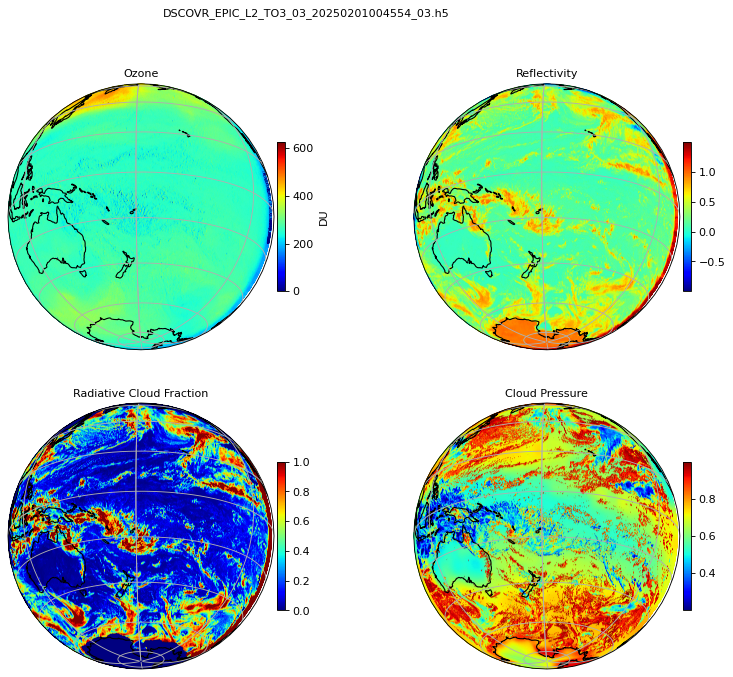

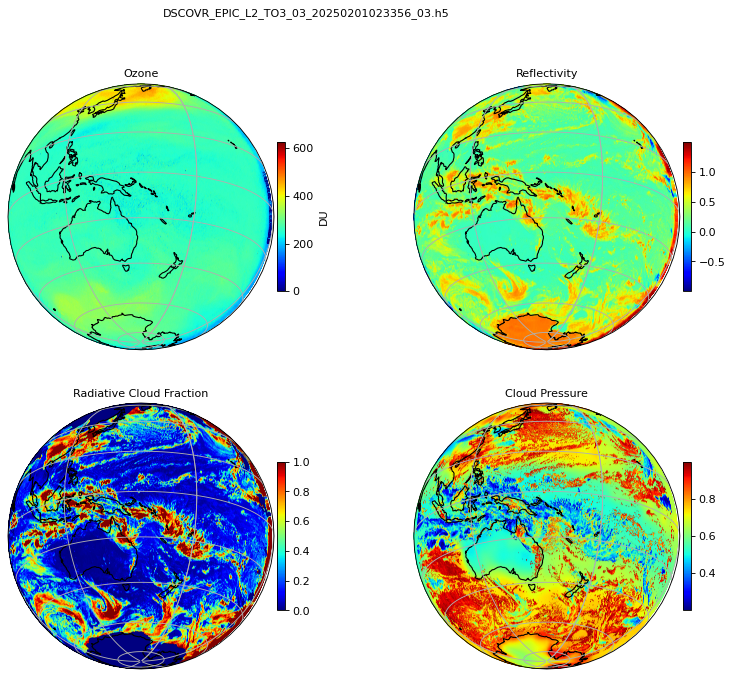

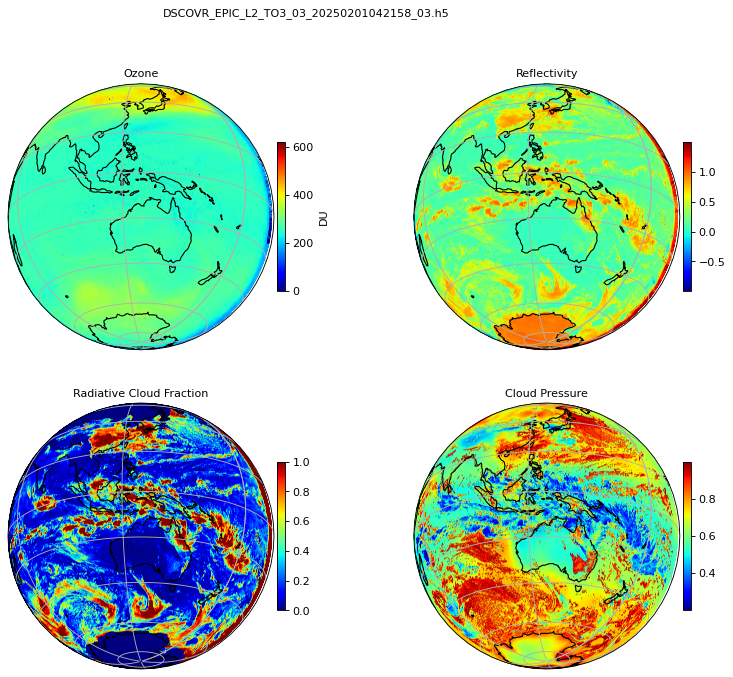

In [7]:
transform = ccrs.PlateCarree()

for i, file in enumerate(downloaded_files):
    lon = arrays["lon"][i]
    lat = arrays["lat"][i]

    # Plot data
    proj = ccrs.Orthographic(
        central_longitude=arrays["lon_m"][i], central_latitude=arrays["lat_m"][i], globe=None
    )

    fig, axs = plt.subplots(
        nrows=2, ncols=2, figsize=(12, 9.5), dpi=80, subplot_kw={"projection": proj}
    )

    axs = axs.flat
    for ax in axs:
        ax.coastlines()
        grid = ax.gridlines()
        grid.top_labels = False
        grid.right_labels = False
        grid.xformatter = LONGITUDE_FORMATTER
        grid.yformatter = LATITUDE_FORMATTER

    im = axs[0].scatter(lon, lat, c=arrays["ozone"][i], s=1, cmap="jet", transform=transform)
    cb = plt.colorbar(im, fraction=0.022, pad=0.01)
    cb.set_label("DU", fontsize=10)
    axs[0].set_title("Ozone", size=10)

    im = axs[1].scatter(lon, lat, c=arrays["reflectivity"][i], s=1, cmap="jet", transform=transform)
    cb = plt.colorbar(im, fraction=0.022, pad=0.01)
    axs[1].set_title("Reflectivity", size=10)

    im = axs[2].scatter(lon, lat, c=arrays["rcf"][i], s=1, cmap="jet", transform=transform)
    cb = plt.colorbar(im, fraction=0.022, pad=0.01)
    axs[2].set_title("Radiative Cloud Fraction", size=10)

    im = axs[3].scatter(lon, lat, c=arrays["cp"][i], s=1, cmap="jet", transform=transform)
    cb = plt.colorbar(im, fraction=0.022, pad=0.01)
    axs[3].set_title("Cloud Pressure", size=10)

    plt.suptitle(f"{file}", fontsize=10)

    plt.savefig(f"{file}.png", dpi=200)
    print(f"Plot has been saved: {file}.png")